In [60]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold

In [61]:
hate_data = pd.read_csv("hate_speech_binary_dataset.csv", delimiter=",") # 혐오 문장
genderbias_data = pd.read_csv('genderbias.csv', sep=',')  # 여성 비하 문장
ilbe_data = pd.read_csv('badword.csv',encoding='CP949') # 일베 문장

## 문장 전처리

In [62]:
# 혐오 문장 처리
hate_data.columns = ['comment', 'label'] # 컬럼 명 변경
hate_data = hate_data.astype({'comment': 'str'})
hate_data = hate_data[hate_data['label']==1]

In [63]:
# 여성 비하 문장 처리
del genderbias_data['bias']    #해당 데이터셋의 필요없는 열 제거
del genderbias_data['hate']    #해당 데이터셋의 필요없는 열 제거
genderbias_data['contain_gender_bias'] = genderbias_data['contain_gender_bias'].replace([False, True],[0,1])  # 구분하기 쉽게 기존의 표기를 0,1로 변경
# genderbias_data = genderbias_data[['contain_gender_bias', 'comments']]    #구분하기 쉽게 열의 순서를 변경

genderbias_data.columns = ['comment', 'label'] # 컬럼 명 변경
genderbias_data = genderbias_data[genderbias_data['label']==1]

In [64]:
# 일베 문장 처리
ilbe_data = ilbe_data[['v2', 'v1']]    #구분하기 쉽게 열의 순서를 변경
ilbe_data.columns = ['comment', 'label'] # 컬럼 명 변경
ilbe_data = ilbe_data[ilbe_data['label']==1]

In [65]:
# 데이터 개수
print("hate_data : %d" % len(hate_data))
print("genderbias_data : %d" % len(genderbias_data))
print("ilbe_data : %d" % len(ilbe_data))

hate_data : 100000
genderbias_data : 1232
ilbe_data : 2044


## 라벨링 및 합치기

In [66]:
# 렌덤하게 문장 추출 후 라벨링 거치는 함수
def random_labeling(data, classified_data, label_num, str_num):  # label_num : 라벨링 시킬 값, str_num 추출할 문장 개수
    random_data = classified_data.sample(n=str_num) # str_num 개의 행(문장) 랜덤 추출
    random_data.loc[random_data.label == 1, 'label'] = label_num # label_num으로 값 변경
    data = data.append(random_data)  # data 에 랜덤 추출된 데이터 추가
    return data

In [67]:
data_declaration = {
    'comment' : ["str_Declaration"],
    'label':[-1]
}


data = pd.DataFrame(data_declaration)
data

,comment,label
0,str_Declaration,-1


In [68]:
# 문장 개수를 모두 2000 개로 지정 각 
# 라벨은 혐오:0, 여성비하: 1, 일베: 2로 지정됨
data = random_labeling(data, hate_data, 0, 2000)
data = random_labeling(data, genderbias_data, 1, 1200)
data = random_labeling(data, ilbe_data, 2, 2000)

In [69]:
# 첫번째 행 제거
data = data.drop(0)

In [70]:
# 랜덤하게 섞기 
data = data.sample(frac=1).reset_index(drop=True)

In [71]:
data[:10]

,comment,label
0,저 새끼 파보면,2
1,목사한테 빤쓰내림!,2
2,너무 재밌어요~~^^ 미스터빈 연기 굿굿굿,0
3,양육비로 생계 유지하면서 나이트에서 남자 데려와서 떡침,2
4,남자들이 불쌍하다 미투니뭐니 나라가 미쳤구나,1
5,난 너무 재밌게봤다... 특히 흉흉한 요즘세상에당사자의 고통과 가장 약했던 여자의 ...,0
6,말이 필요없ㄷㅏ ㅠ ㅠ 한 5번넘게 본 듯,0
7,이런 영화가 많아져야 한다.,0
8,25년전이면 한참 팔팔할때.. 오달수도 아마 이십대 초반.. 서로 어렸을때 반콩깠던...,1
9,실제로 김대중이라고 했는데 김재중이라고 한거라고 구라친거라는 생각은 안해봣노 ?,2


## 중복 및 null 처리

In [72]:
def detect_overlap(data):
    exist_overlap = len(data)  # 데이터 전체 개수
    no_overlap = data['comment'].nunique()  # 중복 제거된 개수
    if exist_overlap != no_overlap:
        data.drop_duplicates(subset=['comment'], inplace=True)

In [73]:
detect_overlap(data)

In [74]:
# null 값 확인
data.isnull().values.any()

False

## 토큰화

In [75]:
def tokenize(x_data, tokenizer):
    tokenizer.fit_on_texts(x_data) # 데이터의 각 행별로 토큰화 수행
    return tokenizer.texts_to_sequences(x_data)    

In [76]:
x_data = data['comment']
y_data = data['label']

In [77]:
tokenizer = Tokenizer()
sequences = tokenize(x_data, tokenizer)

## 희귀단어 확인

In [78]:
def detect_rareword(tokenizer, threshold):
    word_to_index = tokenizer.word_index 
    total_cnt = len(word_to_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    

In [79]:
# 희귀 단어 확인
detect_rareword(tokenizer, 2)

등장 빈도가 1번 이하인 희귀 단어의 수: 23592
단어 집합(vocabulary)에서 희귀 단어의 비율: 83.37279570272467
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 49.086596479547254


## 훈련 데이터, 테스트 데이터 분리

In [80]:
# 가장 긴 길이
def max_length(X_data):
    return max(len(l) for l in X_data)

# 훈련 학습 데이터 개수
def num_dataset(raio, X_data):
    num_train = int(len(X_data)*0.8)
    num_test = int(len(X_data) - num_train)
    return num_train, num_test

Y_data = np.array(y_data)

In [81]:
# 최대 길이 계산
X_data = sequences
maxlen = max_length(X_data)

## 훈련 데이터, 학습 데이터 분할

In [82]:
# 훈련 및 학습 데이터 개수 비율 지정
numtrain, numtest = num_dataset(0.8, X_data)

In [83]:
# 가장 긴 길이로 맞추기
X_data = pad_sequences(X_data, maxlen = maxlen)

In [84]:
X_data

array([[    0,     0,     0, ...,    25,   219,  4706],
       [    0,     0,     0, ...,     0,  4707,  4708],
       [    0,     0,     0, ...,  2273,    53,  4709],
       ...,
       [    0,     0,     0, ..., 28289, 28290,  2215],
       [    0,     0,     0, ..., 28296, 28297,  1433],
       [    0,     0,     0, ...,    65,  1526,    65]], dtype=int32)

In [85]:
Y_data

array([2, 2, 0, ..., 0, 2, 0])

## 모델 학습

In [86]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import tensorflow.keras.metrics 

In [87]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [88]:
size = 1000000

kfold = KFold(n_splits= 5, shuffle = True)

for train, test in kfold.split(X_data, Y_data):
    model = Sequential()
    model.add(Embedding(size , 64, input_length = maxlen)) #워드 임베딩
    model.add(Dropout(0.6)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
    model.add(Conv1D(64, 3, padding='valid', activation='relu')) #hidden layer 추가
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.6)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.6)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
    num_of_class = 3 #클래스는 우선 4개로 분류함
    model.add(Dense(num_of_class, activation='softmax')) #마지막 레이어는 softmax로 출력하게 함
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['acc',f1_m,precision_m, recall_m])
    es = EarlyStopping(monitor='loss', mode='min' , min_delta=0)
    check_point = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', save_best_only=True)
    
    hist = model.fit(X_data, y_data, batch_size = 16, epochs=10, callbacks=[es, check_point])



Epoch 1/10
325/325 [==============================] - 180s 550ms/step - loss: 1.0857 - acc: 0.3854 - f1_m: 3.1065 - precision_m: 116596976.2699 - recall_m: 1.5979
Epoch 2/10
325/325 [==============================] - 187s 575ms/step - loss: 1.0600 - acc: 0.4258 - f1_m: 2.8453 - precision_m: 100664662.0000 - recall_m: 1.4780
Epoch 3/10
325/325 [==============================] - 185s 568ms/step - loss: 0.8568 - acc: 0.6049 - f1_m: 1.7152 - precision_m: 2.5086 - recall_m: 1.4537
Epoch 4/10
325/325 [==============================] - 184s 565ms/step - loss: 0.5682 - acc: 0.7611 - f1_m: 1.1435 - precision_m: 1.0237 - recall_m: 1.3448
Epoch 5/10
325/325 [==============================] - 181s 557ms/step - loss: 0.3416 - acc: 0.8707 - f1_m: 0.9084 - precision_m: 0.7481 - recall_m: 1.1887
Epoch 6/10
325/325 [==============================] - 173s 533ms/step - loss: 0.2006 - acc: 0.9438 - f1_m: 0.8137 - precision_m: 0.6660 - recall_m: 1.0746
Epoch 7/10
325/325 [==============================] - 

## Training

In [32]:
hist = model.fit(X_train, y_train, batch_size = 16, epochs=10, callbacks=[es, check_point])

Epoch 1/10
260/260 [==============================] - 127s 489ms/step - loss: 1.0904 - accuracy: 0.3751
Epoch 2/10
260/260 [==============================] - 129s 494ms/step - loss: 1.0737 - accuracy: 0.3922
Epoch 3/10
260/260 [==============================] - 130s 501ms/step - loss: 1.0205 - accuracy: 0.4742
Epoch 4/10
260/260 [==============================] - 131s 505ms/step - loss: 0.6973 - accuracy: 0.7045
Epoch 5/10
260/260 [==============================] - 133s 511ms/step - loss: 0.4449 - accuracy: 0.8346
Epoch 6/10
260/260 [==============================] - 132s 508ms/step - loss: 0.2696 - accuracy: 0.9127
Epoch 7/10
260/260 [==============================] - 133s 512ms/step - loss: 0.1363 - accuracy: 0.9605
Epoch 8/10
260/260 [==============================] - 132s 506ms/step - loss: 0.0865 - accuracy: 0.9739
Epoch 9/10
260/260 [==============================] - 132s 509ms/step - loss: 0.0745 - accuracy: 0.9817
Epoch 10/10
260/260 [==============================] - 135s 519m

## 결과 확인

KeyError: 'accuracy'

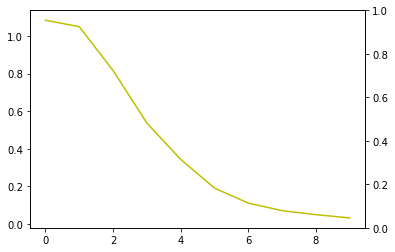

In [89]:
#모델 학습 과정 표시

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
result = pd.DataFrame(model.predict(X_test, batch_size=16),columns=['0', '1', '2'])
result["Test Label"] = y_test

result.to_csv("test_result.csv")

In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_data, Y_data, verbose=0)

In [ ]:
result = pd.DataFrame(model.predict(X_data, batch_size=16),columns=['0', '1', '2'])
result["Test Label"] = Y_data

result.to_csv("test_result.csv")

In [35]:
print("테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

33/33 [==============================] - 0s 2ms/step - loss: 0.8953 - accuracy: 0.7341
테스트 정확도: 0.7341


## 모델 저장

In [36]:
##모델을 .json 파일 형식으로 save하여 저장
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)
    
model.save_weights("model_weight.h5")
model.save('full_model.h5')
print("Model Saved")

Model Saved


In [117]:
##모델 조정이 아직 끝나지 않았습니다. 테스트 정확도를 더 늘리기 위해서 모델을 추가로 수정할 예정입니다,
##모델 조정이 끝나면, Model을 사용 하여 OpenMax에 필요한 자료를 선정하여 OpenMax로 구현할 예정입니다.